In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os

In [34]:
def polargrid2polarbayer(im):
    H,W,_ = im.shape
    im_bayer = np.zeros_like(im)
    im_bayer[0::2, 0::2,:] = im[:H//2,:W//2,:] #
    im_bayer[0::2, 1::2,:] = im[:H//2,W//2:,:]
    im_bayer[1::2, 0::2,:] = im[H//2:,:W//2,:]
    im_bayer[1::2, 1::2,:] = im[H//2:,W//2:,:]
    return im_bayer



In [2]:
# parameters
chess_shape = (7, 8) # row, column
cam_shape = (2048, 2448) # row, column
proj_shape = (684, 608) # row, column
chess_block_size = 10.81
dat_path = './data/procam/20210419/'
cam_calib_path = 'calibration_cam.xml'
gc_step = 1 # should be 1 
black_thr = 3
white_thr = 3

In [3]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
criteria_cal = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)

objps = np.zeros((chess_shape[0]*chess_shape[1], 3), np.float32)
objps[:, :2] = chess_block_size*np.mgrid[0:chess_shape[1], 0:chess_shape[0]].T.reshape(-1, 2)

In [4]:
print('Calibrating ...')
gc_height = int((proj_shape[0]-1)/gc_step)+1
gc_width = int((proj_shape[1]-1)/gc_step)+1
print(gc_height, gc_width)
graycode = cv2.structured_light_GrayCodePattern.create(gc_width, gc_height)
graycode.setBlackThreshold(black_thr)
graycode.setWhiteThreshold(white_thr)

Calibrating ...
684 608


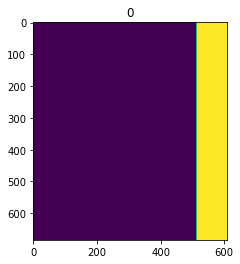

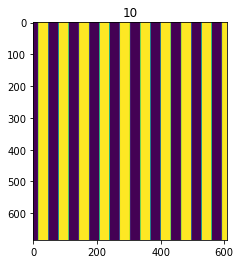

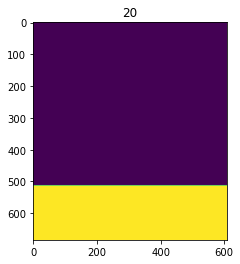

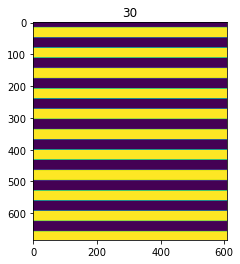

In [5]:
patterns = graycode.generate()[1]
for i in range(0,len(patterns),10):
    plt.imshow(patterns[i])
    plt.title(i)
    plt.show()

In [6]:
dirnames = sorted(glob.glob(os.path.join(dat_path,'calibration*')))
if len(dirnames) == 0:
    print('Directories \'./capture_*\' were not found')
    
print('Searching input files ...')
used_dirnames = []
gc_fname_lists = []
for dname in dirnames:
    gc_fnames = sorted(glob.glob(dname + '/capture_*'))
    if len(gc_fnames) == 0:
        continue
    used_dirnames.append(dname)
    gc_fname_lists.append(gc_fnames)
    print(' \'' + dname + '\' was found')

Searching input files ...
 './data/procam/20210419\calibration0' was found
 './data/procam/20210419\calibration1' was found
 './data/procam/20210419\calibration2' was found
 './data/procam/20210419\calibration3' was found
 './data/procam/20210419\calibration4' was found
 './data/procam/20210419\calibration5' was found
 './data/procam/20210419\calibration6' was found
 './data/procam/20210419\calibration7' was found
 './data/procam/20210419\calibration8' was found
 './data/procam/20210419\calibration9' was found


In [7]:
patch_size_half = int(np.ceil(cam_shape[1] / 180))
print('  patch size :', patch_size_half * 2 + 1)

  patch size : 29


  checking './data/procam/20210419\calibration0'
Error : chessboard was not found in './data/procam/20210419\calibration0\capture_0041.png'
  checking './data/procam/20210419\calibration1'
Error : chessboard was not found in './data/procam/20210419\calibration1\capture_0041.png'
  checking './data/procam/20210419\calibration2'


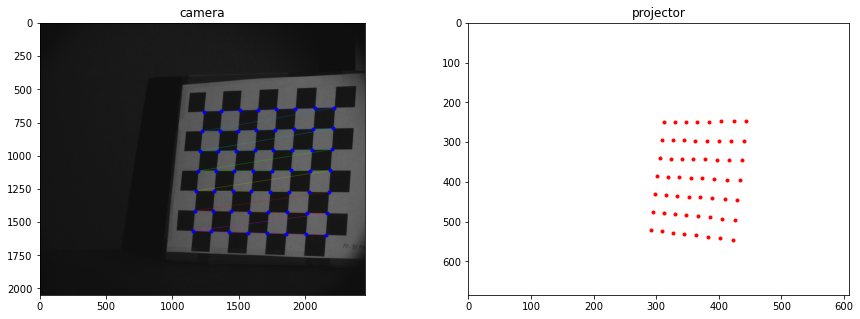

  checking './data/procam/20210419\calibration3'


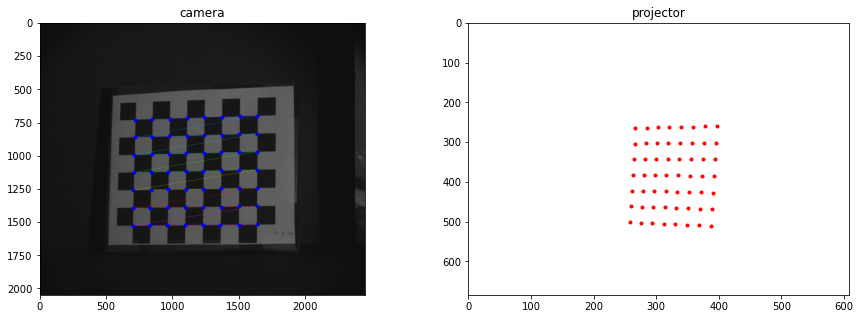

  checking './data/procam/20210419\calibration4'
Error : chessboard was not found in './data/procam/20210419\calibration4\capture_0041.png'
  checking './data/procam/20210419\calibration5'
Error : chessboard was not found in './data/procam/20210419\calibration5\capture_0041.png'
  checking './data/procam/20210419\calibration6'


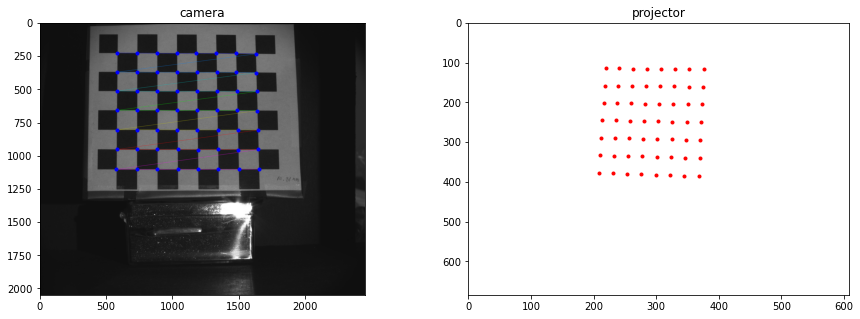

  checking './data/procam/20210419\calibration7'


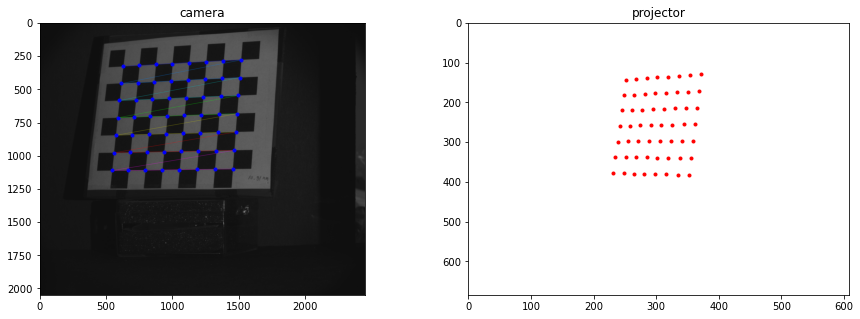

  checking './data/procam/20210419\calibration8'


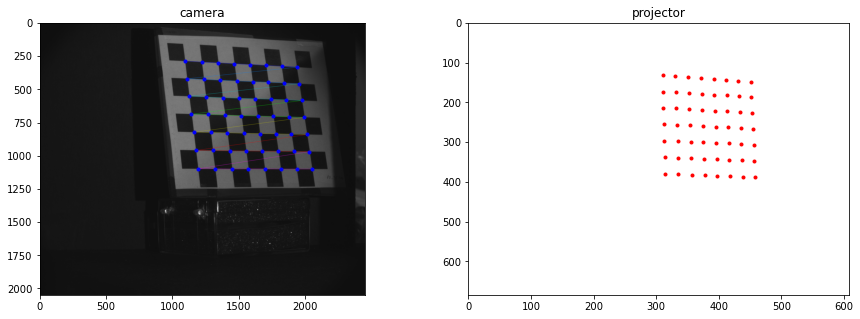

  checking './data/procam/20210419\calibration9'
Error : chessboard was not found in './data/procam/20210419\calibration9\capture_0041.png'


In [13]:
cam_corners_list = []
cam_objps_list = []
cam_corners_list2 = []
proj_objps_list = []
proj_corners_list = []
white_img_list = []
captured_img_list = []
for dname, gc_filenames in zip(dirnames, gc_fname_lists):
    print('  checking \'' + dname + '\'')
    if len(gc_filenames) != graycode.getNumberOfPatternImages() + 2:
        print('Error : invalid number of images in \'' + dname + '\'')

    imgs = []
    for fname in gc_filenames:
        img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/65535
        if cam_shape != img.shape:
            print('Error : image size of \'' + fname + '\' is mismatch')
        imgs.append(img)
    black_img = imgs.pop()
    white_img = imgs.pop()
    white_img = (white_img).astype(np.uint8)

    # Find the chess board corners    
    res, cam_corners = cv2.findChessboardCorners(white_img, (chess_shape[1], chess_shape[0]), None, flags=cv2.CALIB_CB_ADAPTIVE_THRESH)
    if not res:
        print('Error : chessboard was not found in \'' + gc_filenames[-2] + '\'')
        continue
    white_img_list.append(white_img)
    captured_img_list.append(imgs)

#     cam_corners = cv2.cornerSubPix(white_img, cam_corners, (11, 11), (-1, -1), criteria)    
    img_drawn = cv2.drawChessboardCorners(np.stack([white_img,white_img,white_img],axis=-1), (chess_shape[1], chess_shape[0]), cam_corners, res)
#     plt.figure(figsize=(15,15))
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(img_drawn)
    plt.plot(cam_corners[:,0,0],cam_corners[:,0,1], 'b.')
    plt.title('camera')

    cam_objps_list.append(objps)
    cam_corners_list.append(cam_corners)

    proj_objps = []
    proj_corners = []
    cam_corners2 = []
    # viz_proj_points = np.zeros(proj_shape, np.uint8
    plt.subplot(122)
    plt.title('projector')
    plt.ylim([0, proj_shape[0]])
    plt.xlim([0, proj_shape[1]])
    plt.gca().invert_yaxis()
    for corner, objp in zip(cam_corners, objps):
    #     print(corner, objp)
        c_x = int(round(corner[0][0]))
        c_y = int(round(corner[0][1]))
        src_points = []
        dst_points = []

        for dx in range(-patch_size_half, patch_size_half + 1):
            for dy in range(-patch_size_half, patch_size_half + 1):
                x = c_x + dx
                y = c_y + dy
                if int(white_img[y, x]) - int(black_img[y, x]) <= black_thr:
                    continue
                err, proj_pix = graycode.getProjPixel(imgs, x, y)
                if not err:
                    src_points.append((x, y))
                    dst_points.append(gc_step*np.array(proj_pix))
        if len(src_points) < patch_size_half:
            print('    Warning : corner', c_x, c_y, 'was skiped because decoded pixels were too few (check your images and threasholds)')
            continue

        h_mat, inliers = cv2.findHomography(np.array(src_points), np.array(dst_points))
        point = h_mat@np.array([corner[0][0], corner[0][1], 1]).transpose()
        point_pix = point[0:2]/point[2]
        proj_objps.append(objp)
        proj_corners.append([point_pix])
        cam_corners2.append(corner)
#         spnp = np.array(src_points)
#         dpnp = np.array(dst_points)
        pnp = np.array(point_pix)
#         print('src_points', np.array(src_points))
#         print('dst_points', np.array(dst_points))
#         print('point_pix', np.array(point_pix))
#         plt.plot(spnp[:,0],spnp[:,1],'b.')
#         plt.plot(dpnp[:,0],dpnp[:,1],'g.')
        
        plt.plot(pnp[0],pnp[1],'r.')
        
#         break
    plt.show()
    if len(proj_corners) < 3:
        print('Error : too few corners were found in \'' + dname + '\' (less than 3)')
    proj_objps_list.append(np.float32(proj_objps))
    proj_corners_list.append(np.float32(proj_corners))
    cam_corners_list2.append(np.float32(cam_corners2))

In [15]:
from scipy.spatial import cKDTree
import time

def compute_inverse_map(map1, map2, shape1, shape2):
    '''
    map1: x mapping
    map2: y mapping
    '''
    
    h,w = shape1
    H,W = shape2
    
    map1_inverse = np.zeros((H, W))
    map2_inverse = np.zeros((H, W))

    s = time.time()

    data = []
    coords = []
    for j in range(w):
        for i in range(h):
            data.append([map1[i, j], map2[i, j]])
            coords.append((i, j))
    data = np.array(data)
    tree = cKDTree(data, leafsize=16, compact_nodes=True, balanced_tree=True)
    coords.append((0, 0))  # extra coords for failed neighbour search

    e1 = time.time()
    print("Tree creation took {:0.2f} seconds".format(e1-s))

    x = np.linspace(0.0, W, num=W, endpoint=False)
    y = np.linspace(0.0, H, num=H, endpoint=False)
    pts = np.array(np.meshgrid(x, y)).T.reshape(-1, 2)
    distances, indices = tree.query(pts, k=5, p=2, distance_upper_bound=5.0)

    e2 = time.time()
    print("Tree query took {:0.2f} seconds".format(e2-e1))

    # TODO optimization (any suggestions? :S)
    for (x, y), ds, idxs in zip(pts.astype(np.uint16), distances, indices):
        wsum_i = 0
        wsum_j = 0
        wsum = np.finfo(float).eps
        for d, idx in zip(ds, idxs):
            w = 1.0 / (d*d)
            wsum += w
            wsum_i += w*coords[idx][0]
            wsum_j += w*coords[idx][1]
        wsum_i /= wsum
        wsum_j /= wsum
        map1_inverse[y, x] = wsum_j
        map2_inverse[y, x] = wsum_i

    e3 = time.time()
    print("Weighted sums took {:0.2f} seconds".format(e3-e2))
    map1_inverse = map1_inverse.astype(np.float32)
    map2_inverse = map2_inverse.astype(np.float32)
    return map1_inverse, map2_inverse


loaded camera intrinsic
[[7.83886573e+03 0.00000000e+00 1.12911492e+03]
 [0.00000000e+00 7.86957996e+03 8.58101683e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
loaded camera distortion
[[-2.23793876e-01  1.67910299e+00 -1.00469307e-02 -3.55336345e-03
  -1.18155270e+01]]
Tree creation took 11.06 seconds
Tree query took 5.09 seconds


C:\Users\PCI_Custom\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\PCI_Custom\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\PCI_Custom\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


Weighted sums took 51.00 seconds


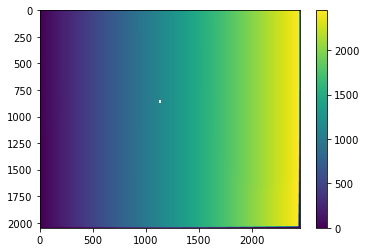

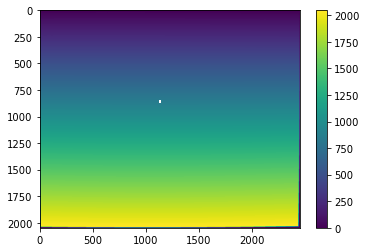

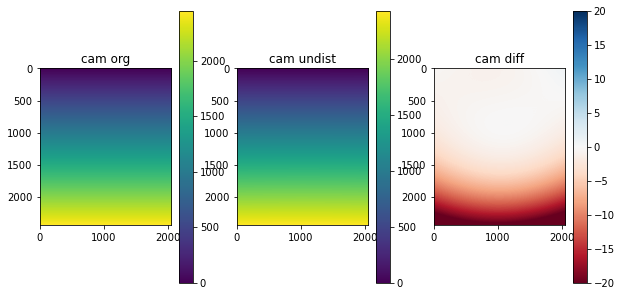

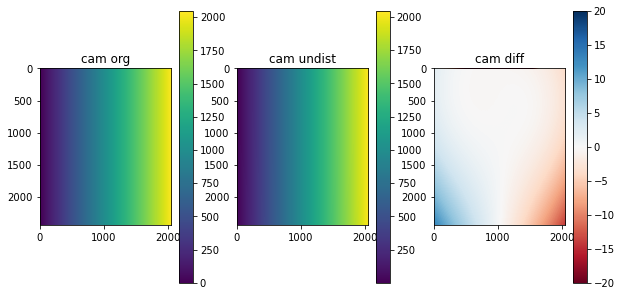

In [16]:
cam_s = cv2.FileStorage(cam_calib_path, cv2.FileStorage_READ)
cam_int = cam_s.getNode("cam_int").mat()
cam_dist = cam_s.getNode("cam_dist").mat()
cam_map_x = cam_s.getNode("mapx").mat()
cam_map_y = cam_s.getNode("mapy").mat()
print('loaded camera intrinsic')
print(cam_int)
print('loaded camera distortion')
print(cam_dist)

cam_map_x_inv, cam_map_y_inv = compute_inverse_map(cam_map_x, cam_map_y, cam_shape, cam_shape)
plt.imshow(cam_map_x_inv)
plt.colorbar()
plt.show()
plt.imshow(cam_map_y_inv)
plt.colorbar()
plt.show()

cam_inds = np.mgrid[0:cam_shape[1], 0:cam_shape[0]].astype(np.float)
cam_pattern_h = cam_inds[0,:,:]
cam_pattern_h_rec = cv2.undistort(cam_pattern_h, cam_int, cam_dist, None, cam_int)
cam_pattern_v = cam_inds[1,:,:]
cam_pattern_v_rec = cv2.undistort(cam_pattern_v, cam_int, cam_dist, None, cam_int)
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(cam_pattern_h)
plt.title('cam org')
plt.colorbar()
plt.subplot(132)
plt.imshow(cam_pattern_h_rec)
plt.title('cam undist')
plt.colorbar()
plt.subplot(133)
plt.imshow(cam_pattern_h_rec-cam_pattern_h,vmin=-20,vmax=20,cmap='RdBu')
plt.title('cam diff')
plt.colorbar()
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(cam_pattern_v)
plt.title('cam org')
plt.colorbar()
plt.subplot(132)
plt.imshow(cam_pattern_v_rec)
plt.title('cam undist')
plt.colorbar()
plt.subplot(133)
plt.imshow(cam_pattern_v_rec-cam_pattern_v,vmin=-20,vmax=20,cmap='RdBu')
plt.title('cam diff')
plt.colorbar()


Initial solution of projector's parameters
  RMS : 0.2054743933059516
  Intrinsic parameters :
[[1.14269220e+03 0.00000000e+00 2.81723393e+02]
 [0.00000000e+00 2.28618966e+03 6.37778755e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]     
  Distortion parameters :
[[-3.04447970e-01  3.85058378e+00 -8.41275286e-03 -1.71380930e-03
  -3.06628986e+01]]     



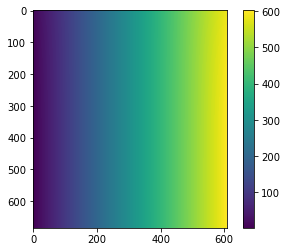

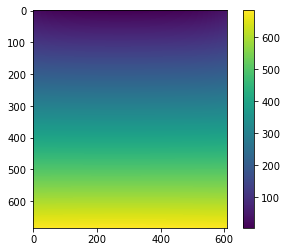

In [17]:
print('Initial solution of projector\'s parameters')
ret, proj_int, proj_dist, proj_rvecs, proj_tvecs = cv2.calibrateCamera(proj_objps_list, proj_corners_list, proj_shape, None, None, None, None)
print('  RMS :', ret)
print('  Intrinsic parameters :')
print(proj_int, '    ')
print('  Distortion parameters :')
print(proj_dist, '    ')
print()

proj_map_x, proj_map_y = cv2.initUndistortRectifyMap(proj_int, proj_dist, np.eye(3), proj_int, proj_shape[::-1], cv2.CV_32FC1)
plt.imshow(proj_map_x)
plt.colorbar()
plt.show()
plt.imshow(proj_map_y)
plt.colorbar()

Tree creation took 0.67 seconds
Tree query took 0.42 seconds


C:\Users\PCI_Custom\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\PCI_Custom\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\PCI_Custom\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in double_scalars


Weighted sums took 4.19 seconds


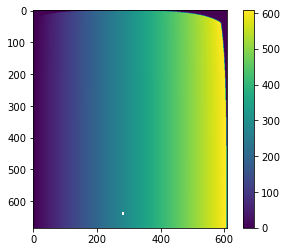

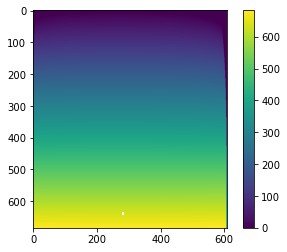

In [18]:
proj_map_x_inv, proj_map_y_inv = compute_inverse_map(proj_map_x, proj_map_y, proj_shape, proj_shape)
plt.imshow(proj_map_x_inv)
plt.colorbar()
plt.show()
plt.imshow(proj_map_y_inv)
plt.colorbar()
plt.show()

In [19]:
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC
# flags |= cv2.CALIB_FIX_PRINCIPAL_POINT
# flags |= cv2.CALIB_USE_INTRINSIC_GUESS
# flags |= cv2.CALIB_FIX_FOCAL_LENGTH
# flags |= cv2.CALIB_FIX_ASPECT_RATIO
# flags |= cv2.CALIB_ZERO_TANGENT_DIST
# flags |= cv2.CALIB_RATIONAL_MODEL
# flags |= cv2.CALIB_SAME_FOCAL_LENGTH
# flags |= cv2.CALIB_FIX_K3
# flags |= cv2.CALIB_FIX_K4
# flags |= cv2.CALIB_FIX_K5

In [20]:
print('=== Result ===')
ret, cam_int, cam_dist, proj_int, proj_dist, cam_proj_rmat, cam_proj_tvec, E, F = cv2.stereoCalibrate(
    proj_objps_list, cam_corners_list2, proj_corners_list, cam_int, cam_dist, proj_int, proj_dist, cam_shape, flags=flags)

print('  RMS :', ret)
print('  Camera intrinsic parameters :')
print(cam_int, '    ')
print('  Camera distortion parameters :')
print(cam_dist, '    ')
print('  Projector intrinsic parameters :')
print(proj_int, '    ')
print('  Projector distortion parameters :')
print(proj_dist, '    ')
print('  Rotation matrix / translation vector from camera to projector')
print('  (they translate points from camera coord to projector coord) :')
print(cam_proj_rmat, '    ')
print(cam_proj_tvec, '    ')
print('  Fundamental matrix :')
print(F, '    ')
print('  Epipolar matrix :')
print(E, '    ')
print()

=== Result ===
  RMS : 0.6500816452681131
  Camera intrinsic parameters :
[[7.83886573e+03 0.00000000e+00 1.12911492e+03]
 [0.00000000e+00 7.86957996e+03 8.58101683e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]     
  Camera distortion parameters :
[[-2.23793876e-01  1.67910299e+00 -1.00469307e-02 -3.55336345e-03
  -1.18155270e+01]]     
  Projector intrinsic parameters :
[[1.14269220e+03 0.00000000e+00 2.81723393e+02]
 [0.00000000e+00 2.28618966e+03 6.37778755e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]     
  Projector distortion parameters :
[[-3.04447970e-01  3.85058378e+00 -8.41275286e-03 -1.71380930e-03
  -3.06628986e+01]]     
  Rotation matrix / translation vector from camera to projector
  (they translate points from camera coord to projector coord) :
[[ 0.9721607  -0.01677818  0.23371364]
 [ 0.05257991  0.98761679 -0.14781214]
 [-0.22833949  0.15598579  0.96100443]]     
[[-124.82468948]
 [   4.68793956]
 [   1.92822983]]     
  Fundamental matrix :
[[ 4.461

In [21]:
fs = cv2.FileStorage('calibration_procam.xml', cv2.FILE_STORAGE_WRITE)
fs.write('img_shape', cam_shape)
fs.write('rms', ret)
fs.write('cam_int', cam_int)
fs.write('cam_dist', cam_dist)
fs.write('proj_int', proj_int)
fs.write('proj_dist', proj_dist)
fs.write('rotation', cam_proj_rmat)
fs.write('translation', cam_proj_tvec)
fs.write('fundamental', F)
fs.write('epipolar',E)
fs.release()


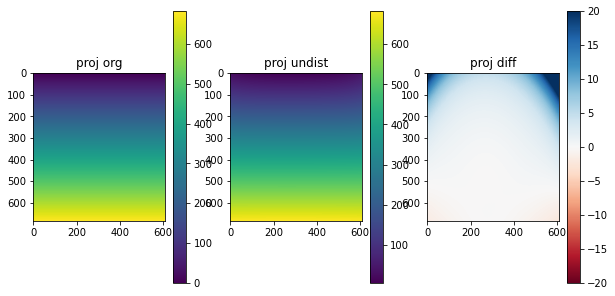

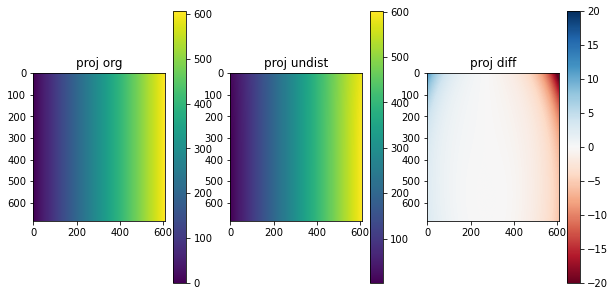

In [22]:
proj_inds = np.mgrid[0:proj_shape[0], 0:proj_shape[1]].astype(np.float)
proj_pattern_h = proj_inds[0,:,:]
proj_pattern_h_rec = cv2.undistort(proj_pattern_h, proj_int, proj_dist, None, proj_int)
proj_pattern_v = proj_inds[1,:,:]
proj_pattern_v_rec = cv2.undistort(proj_pattern_v, proj_int, proj_dist, None, proj_int)
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(proj_pattern_h)
plt.title('proj org')
plt.colorbar()
plt.subplot(132)
plt.imshow(proj_pattern_h_rec)
plt.title('proj undist')
plt.colorbar()
plt.subplot(133)
plt.imshow(proj_pattern_h_rec-proj_pattern_h,vmin=-20,vmax=20,cmap='RdBu')
plt.title('proj diff')
plt.colorbar()
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.imshow(proj_pattern_v)
plt.title('proj org')
plt.colorbar()
plt.subplot(132)
plt.imshow(proj_pattern_v_rec)
plt.title('proj undist')
plt.colorbar()
plt.subplot(133)
plt.imshow(proj_pattern_v_rec-proj_pattern_v,vmin=-20,vmax=20,cmap='RdBu')
plt.title('proj diff')
plt.colorbar()




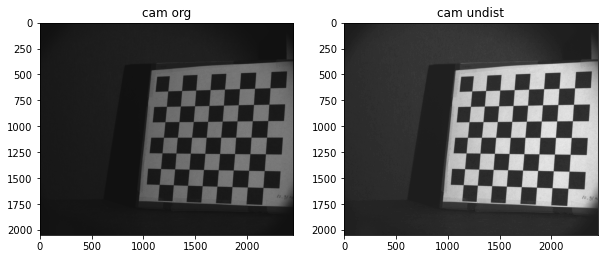

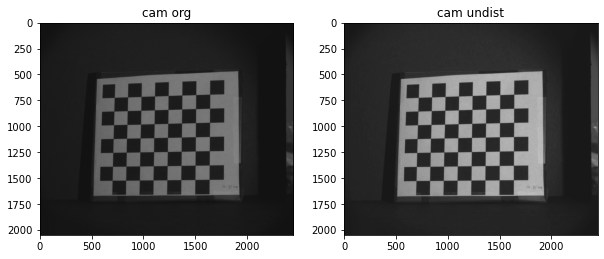

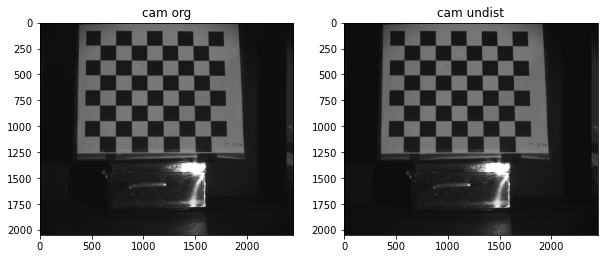

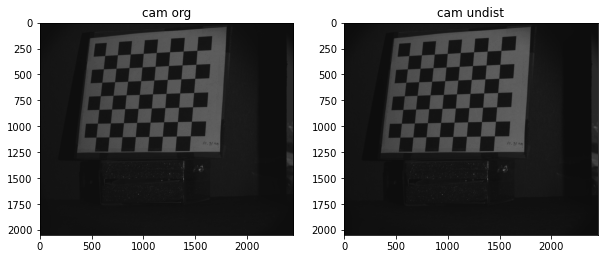

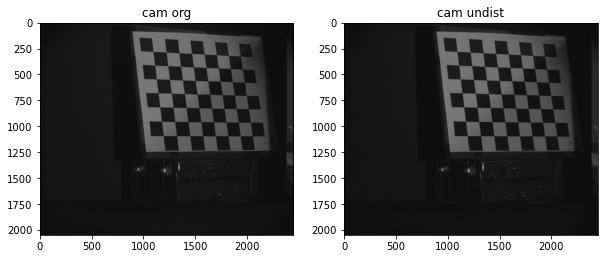

In [23]:
for i in range(len(white_img_list)):
    # rec
    white_img_list_rec = cv2.undistort(white_img_list[i], cam_int, cam_dist, cam_int)
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(white_img_list[i], cmap='gray')
    plt.title('cam org')
    plt.subplot(122)
    plt.imshow(white_img_list_rec, cmap='gray')
    plt.title('cam undist')

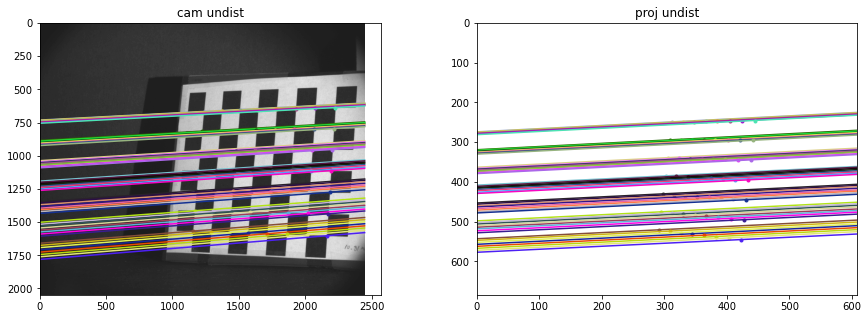

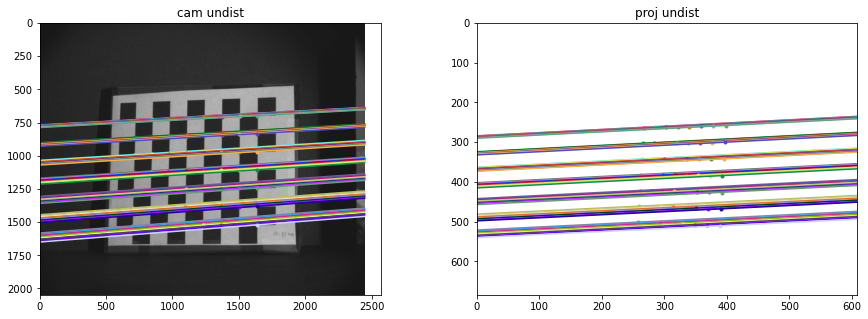

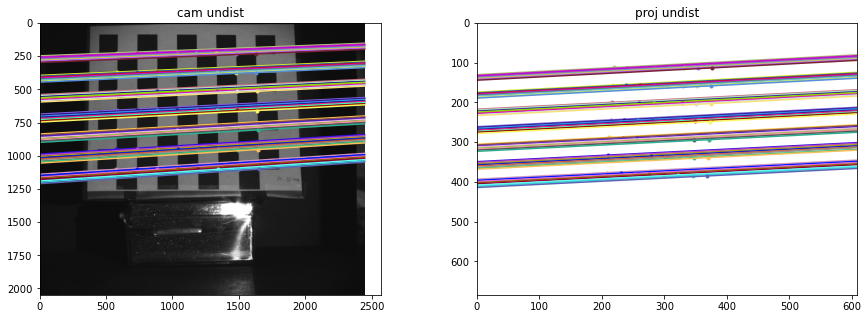

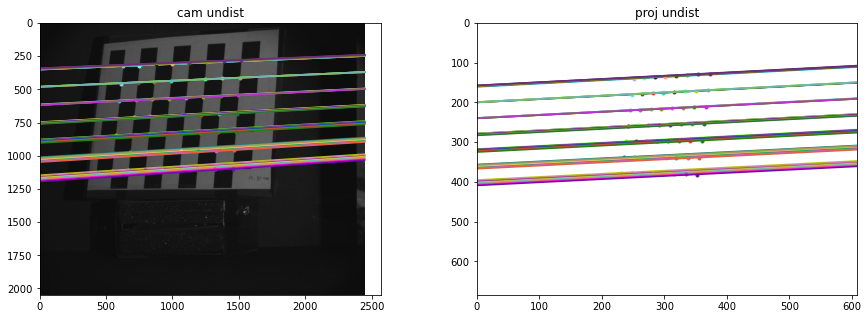

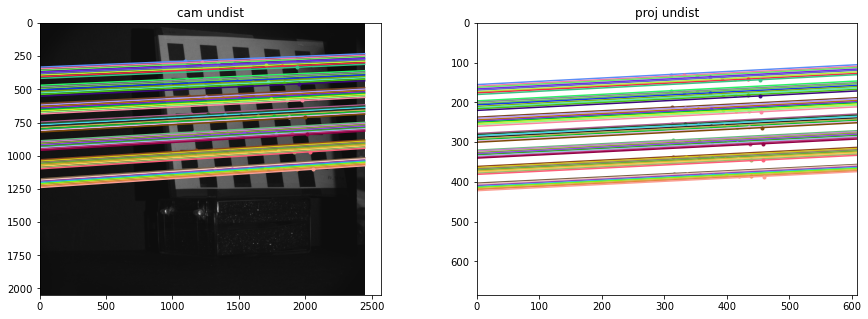

In [24]:
for i in range(len(white_img_list)):
    # rec
    white_img_list_rec = cv2.undistort(white_img_list[i], cam_int, cam_dist, None, cam_int)

    cx = cam_corners_list[i][:,0,0]
    cy = cam_corners_list[i][:,0,1]
    px = proj_corners_list[i][:,0,0]
    py = proj_corners_list[i][:,0,1]
    
    c_u = cv2.undistortPoints(cam_corners_list[i], cam_int, cam_dist, None, cam_int)
    p_u = cv2.undistortPoints(proj_corners_list[i], proj_int, proj_dist, None, proj_int)
    
    lines1 = cv2.computeCorrespondEpilines(p_u, 2, F)
    lines1 = lines1.reshape(-1,3)
        
    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image
    lines2 = cv2.computeCorrespondEpilines(c_u, 1,F)
    lines2 = lines2.reshape(-1,3)
    
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.imshow(white_img_list_rec, cmap='gray')
    colors = []
    for j in range(len(cx)):
        r = lines1[j]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [cam_shape[1], -(r[2]+r[0]*cam_shape[1])/r[1] ])

        color = tuple(np.random.randint(0,255,3).tolist())
        color = [x/255 for x in color]
        colors.append(color)
#         print(color)
        plt.plot(c_u[j,0,0],c_u[j,0,1],'.', c=color)
        plt.plot([x0,x1],[y0,y1], c=color)
#     plt.plot(c_u[:,0,0],c_u[:,0,1],'r.')
    plt.title('cam undist')
    plt.subplot(122)
#     plt.plot(p_u[:,0,0],p_u[:,0,1],'r.')
    for j in range(len(px)):
        r = lines2[j]
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [proj_shape[1], -(r[2]+r[0]*proj_shape[1])/r[1] ])

#         print(color)
        plt.plot(p_u[j,0,0],p_u[j,0,1],'.', c=colors[j])
        plt.plot([x0,x1],[y0,y1], c=colors[j])
    plt.ylim([0, proj_shape[0]])
    plt.xlim([0, proj_shape[1]])
    plt.gca().invert_yaxis()
    plt.title('proj undist')

In [25]:
# ------- prepare epi maps -------
# for each pixel in the camera distorted space
#     compute the undistorted camera pixel
#     compute the corresponding epipolar line on the projector undistorted space 
#     get the zero-intersected row coordinate of the epipolar line
#     assign the value to the pixel in the camera distorted epi map
#     assign the value to the all pixels on the line in the projector undistorted epi map (count, sum)

In [26]:
from skimage.draw import line_aa

y,x = np.mgrid[0:cam_shape[0], 0:cam_shape[1]]
y = y.reshape(-1,1)
x = x.reshape(-1,1)

# cam_epi_map = np.zeros(cam_shape)

c = np.stack([x,y],-1).astype(np.float32)
c_u = cv2.undistortPoints(c, cam_int, cam_dist, None, cam_int)

epi_line_proj = cv2.computeCorrespondEpilines(c_u, 1,F)
epi_line_proj = epi_line_proj.reshape(-1,3)

x_p_0 = 0
y_p_0 = -epi_line_proj[:,2]/epi_line_proj[:,1]
x_p_1 = proj_shape[1]-1
y_p_1 = (-epi_line_proj[:,2]-epi_line_proj[:,0]*x_p_1)/epi_line_proj[:,1]
y_p_0 = y_p_0.reshape(cam_shape)
y_p_1 = y_p_1.reshape(cam_shape)
cam_epi_map = y_p_0
epi_line_proj = epi_line_proj.reshape(*cam_shape, 3)

In [27]:
proj_epi_map_u = np.zeros(proj_shape)
proj_epi_map_u_cnt = np.zeros(proj_shape)

xy_list = []

# left column 
for y in range(cam_shape[0]):
    xy_list.append( [0,y] )
# right column 
for y in range(cam_shape[0]):
    xy_list.append( [cam_shape[1]-1,y] )
# middle column 
for y in range(cam_shape[0]):
    xy_list.append( [cam_shape[1]//2-1,y] )
# top row
for x in range(cam_shape[1]):
    xy_list.append( [x,0] )
# bottom row
for x in range(cam_shape[1]):
    xy_list.append( [x,cam_shape[0]-1] )
# middle row
for x in range(cam_shape[1]):
    xy_list.append( [x,cam_shape[0]//2-1] )

for xy in xy_list:
    x,y = xy
    y_p_0_yx = y_p_0[y,x]
    
    # get the pixels on the epipolar line
    rr,cc,val = line_aa(*(y_p_0[y,x].astype(np.int),x_p_0), *(y_p_1[y,x].astype(np.int),x_p_1))
    for r,c,v in zip(rr,cc,val):
        
        # make the projector epipolar line map in the undistorted space
        if 0<= r < proj_shape[0] and 0<= c < proj_shape[1]:
            proj_epi_map_u[r, c] += y_p_0_yx*v
            proj_epi_map_u_cnt[r, c] += v
            
proj_epi_map_u = proj_epi_map_u/proj_epi_map_u_cnt
proj_epi_map_u[np.isnan(proj_epi_map_u)] = 0

C:\Users\PCI_Custom\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


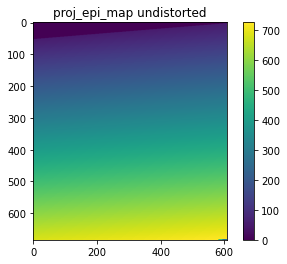

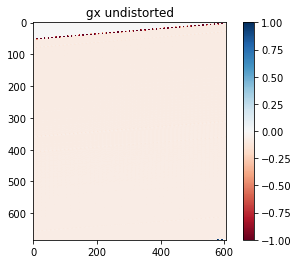

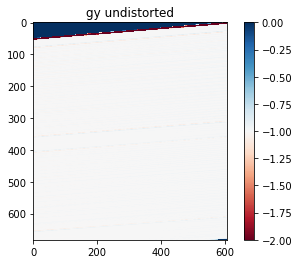

In [28]:
plt.figure()
plt.imshow(proj_epi_map_u)
plt.colorbar()
plt.title('proj_epi_map undistorted')

plt.figure()
gx = proj_epi_map_u[:,:-1] - proj_epi_map_u[:,1:]
plt.imshow(gx, vmin=-1,vmax=1, cmap='RdBu')
plt.title('gx undistorted')
plt.colorbar()

plt.figure()
gy = proj_epi_map_u[:-1,:] - proj_epi_map_u[1:,:]
plt.imshow(gy, vmin=-2,vmax=0, cmap='RdBu')
plt.title('gy undistorted')
plt.colorbar()


In [29]:
proj_epi_map = cv2.remap(proj_epi_map_u, proj_map_x_inv, proj_map_y_inv, cv2.INTER_LINEAR)

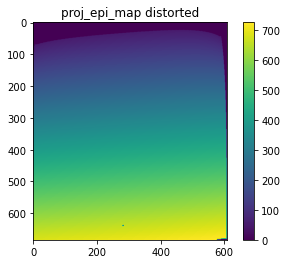

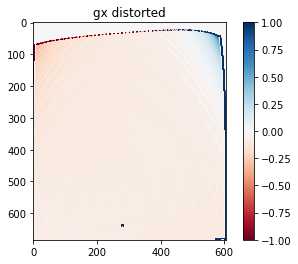

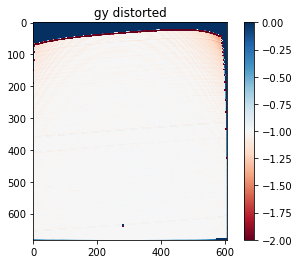

In [30]:

plt.figure()
plt.imshow(proj_epi_map)
plt.colorbar()
plt.title('proj_epi_map distorted')

plt.figure()
gx = proj_epi_map[:,:-1] - proj_epi_map[:,1:]
plt.imshow(gx, vmin=-1,vmax=1, cmap='RdBu')
plt.title('gx distorted')
plt.colorbar()

plt.figure()
gy = proj_epi_map[:-1,:] - proj_epi_map[1:,:]
plt.imshow(gy, vmin=-2,vmax=0, cmap='RdBu')
plt.title('gy distorted')
plt.colorbar()

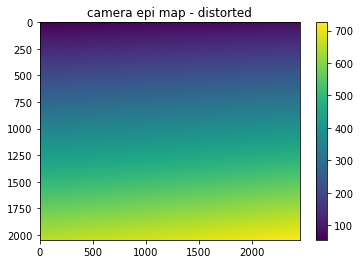

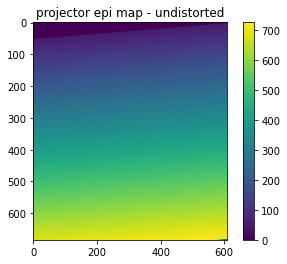

In [31]:
plt.imshow(cam_epi_map)
plt.colorbar()
plt.title('camera epi map - distorted')
plt.show()
plt.imshow(proj_epi_map_u)
plt.colorbar()
plt.title('projector epi map - undistorted')
plt.show()

In [32]:
np.save('cam_epi_map.npy', cam_epi_map)
np.save('proj_epi_map_u.npy', proj_epi_map_u)
np.save('proj_epi_map.npy', proj_epi_map)

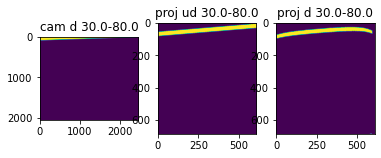

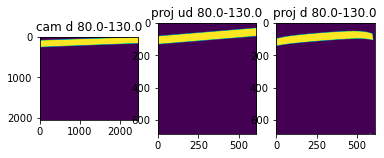

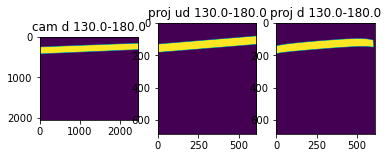

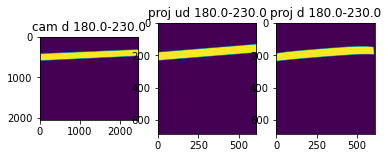

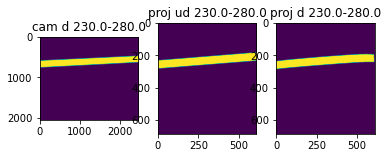

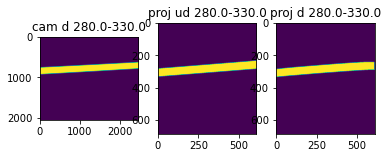

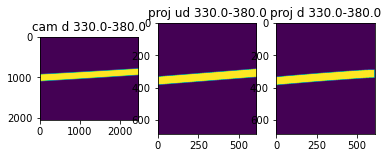

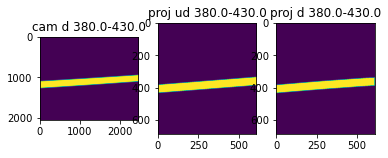

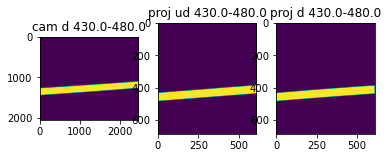

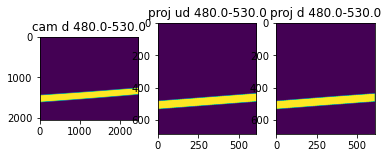

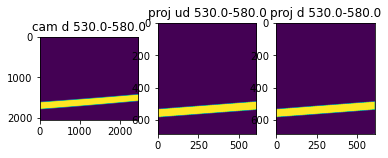

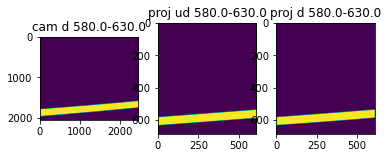

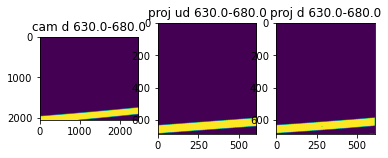

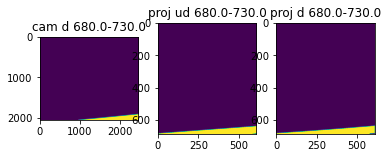

In [33]:
minv = cam_epi_map.min()
maxv = cam_epi_map.max()
step = 50

line_vals = np.arange(minv, maxv, step)
for l in line_vals:
    l_min = l - step/2
    l_max = l + step/2
    cam_mask = (l_min<= cam_epi_map) * (cam_epi_map <= l_max)
    proj_mask_u =  (l_min<= proj_epi_map_u) * (proj_epi_map_u <= l_max)
    proj_mask =  (l_min<= proj_epi_map) * (proj_epi_map <= l_max)
    plt.subplot(131)
    plt.imshow(cam_mask)
    plt.title('cam d %.1f-%.1f'%(l_min, l_max))
    plt.subplot(132)
    plt.imshow(proj_mask_u)
    plt.title('proj ud %.1f-%.1f'%(l_min, l_max))
    plt.subplot(133)
    plt.imshow(proj_mask)
    plt.title('proj d %.1f-%.1f'%(l_min, l_max))
    plt.show()

In [28]:
# ------- capture procedure ------- 
# for each epipolar region (step size, width)
#   compute the camera distorted ROI from the camera epi map
#   compute the projector undistorted ROI from the projector epi map
#   project the project pattern 
#   capture the camera pattern with on the camera distorted ROI
#   aggregate the captured image